# Determine Optimal Experimental Conditions

**Cell Morphology Quantitative Trait Loci (cmQTL) Project**

**Gregory Way, 2019**

We performed a pilot experiment to determine optimal conditions to collect cell painting data.

The conditions included testing `plating density` and `plating time` across 6 different `primary cell lines`.
Each condition and cell line were tested with 16 replicates.

We are also interested in testing these conditions using profiles generated by isolated single cells, and cells forming colonies.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggridges))
suppressPackageStartupMessages(library(corrplot))

In [2]:
set.seed(123)

In [3]:
# Read in both btches of data
profile_dir <- file.path("..", "..", "..", "backend", "2019_05_13_Batch2")
profile_files <- list.files(profile_dir,
                            recursive = TRUE,
                            full.names = TRUE,
                            pattern = "variable_selected.csv")

profile_cols <- readr::cols(
    .default = readr::col_double(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_Assay_Plate_Barcode = readr::col_character(),
    Metadata_Plate_Map_Name = readr::col_character(),
    Metadata_well_position = readr::col_character(),
    Metadata_plating_density = readr::col_integer(),
    Metadata_line_ID = readr::col_character(),
    Metadata_timepoint = readr::col_integer()
)

profile_list <- list()
for (norm_file in profile_files) {
    if (grepl("colony", norm_file)) {
        profile_type <- "colony"
    } else if (grepl("isolated", norm_file)) {
        profile_type <- "isolated"
    } else {
        profile_type <- "all"
    }
    
    profile_list[[norm_file]] <-
    readr::read_csv(norm_file, col_types = profile_cols) %>%
        dplyr::mutate(Metadata_profile_type = profile_type)
    
}

profile_df <- do.call(rbind, profile_list) %>% tibble::remove_rownames()

# Note that with the addition of single cell data, some variables recieve NA
head(sort(colSums(is.na(profile_df)), decreasing = TRUE))

# We need to drop these
profile_df <- profile_df %>% dplyr::select_if(~ !any(is.na(.)))

dim(profile_df)
table(profile_df$Metadata_profile_type)
head(profile_df, 2)

Nuclei_Correlation_Costes_DNA_ER    Nuclei_Correlation_Costes_DNA_RNA 
                                 972                                  752 
Nuclei_Neighbors_NumberOfNeighbors_2   Nuclei_Correlation_Costes_DNA_Mito 
                                 585                                  526 
         Cells_AreaShape_EulerNumber                       Metadata_Plate 
                                 335                                    0

[1] 2228  593


     all   colony isolated 
     768      692      768 

Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_plating_density,Metadata_line_ID,Metadata_timepoint,Cells_AreaShape_Compactness,Cells_AreaShape_FormFactor,⋯,Nuclei_Texture_InverseDifferenceMoment_DNA_20_03,Nuclei_Texture_SumAverage_Brightfield_20_02,Nuclei_Texture_SumAverage_DNA_20_02,Nuclei_Texture_SumAverage_ER_20_03,Nuclei_Texture_SumEntropy_ER_20_01,Nuclei_Texture_SumVariance_AGP_20_03,Nuclei_Texture_SumVariance_DNA_20_01,Nuclei_Texture_SumVariance_ER_20_03,Nuclei_Texture_SumVariance_Mito_20_01,Metadata_profile_type
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
BR00103267,A02,BR00103267,cmQTL1-4_mt,A02,5000,A,6,1.376367,-3.417836,⋯,-0.52698741,-3.4863542,-1.8237935,-1.3604198,-3.0283602,1.4574340,-0.9151039,-0.35537334,0.08163407,colony
BR00103267,A03,BR00103267,cmQTL1-4_mt,A03,15000,B,6,1.197074,-1.236257,⋯,-0.08038438,0.2450205,-0.1614993,0.6656642,-0.1439801,0.6399359,-0.3822797,0.09495467,0.07204388,colony


In [4]:
# Separate different cell profiler data
cp_features <- colnames(profile_df) %>%
    stringr::str_subset("^Nuclei_|^Cells_|^Cytoplasm_")

length(cp_features)

cp_metadata <- colnames(profile_df) %>%
    stringr::str_subset("^Metadata_")

length(cp_metadata)

[1] 584

[1] 9

In [5]:
# Create a metadata dictionary and dummy variable "group_id"
# "group_id" distinguishes each separate condition including cell line
# "condition_group_id" distinguishes separate conditions ignoring cell line
metadata_df <- profile_df %>%
    dplyr::select(cp_metadata) %>%
    dplyr::mutate(dictionary_id = paste0("id_", dplyr::row_number()),
                  group_id = group_indices(.,
                                           Metadata_profile_type,
                                           Metadata_line_ID,
                                           Metadata_plating_density,
                                           Metadata_timepoint,
                                           Metadata_Plate),
                  condition_group_id = group_indices(.,
                                                     Metadata_profile_type,
                                                     Metadata_plating_density,
                                                     Metadata_timepoint,
                                                     Metadata_Plate))

tail(metadata_df)

Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_plating_density,Metadata_line_ID,Metadata_timepoint,Metadata_profile_type,dictionary_id,group_id,condition_group_id
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>
BR00103268,P19,BR00103268,cmQTL5-8_mt,P19,3000,B,24,all,id_2223,11,3
BR00103268,P20,BR00103268,cmQTL5-8_mt,P20,3000,B,24,all,id_2224,11,3
BR00103268,P21,BR00103268,cmQTL5-8_mt,P21,2000,A,24,all,id_2225,2,2
BR00103268,P22,BR00103268,cmQTL5-8_mt,P22,2000,A,24,all,id_2226,2,2
BR00103268,P23,BR00103268,cmQTL5-8_mt,P23,3000,C,24,all,id_2227,19,3
BR00103268,P24,BR00103268,cmQTL5-8_mt,P24,3000,C,24,all,id_2228,19,3


In [6]:
# Create a dataframe of variables for each group
group_id_df <- metadata_df %>%
    dplyr::select(group_id,
                  Metadata_profile_type,
                  Metadata_line_ID,
                  Metadata_timepoint,
                  Metadata_plating_density) %>%
    dplyr::distinct() %>%
    dplyr::arrange(group_id)

dim(group_id_df)
tail(group_id_df)

[1] 144   5

group_id,Metadata_profile_type,Metadata_line_ID,Metadata_timepoint,Metadata_plating_density
<int>,<chr>,<chr>,<int>,<int>
139,isolated,F,24,3000
140,isolated,F,24,4000
141,isolated,F,6,5000
142,isolated,F,6,10000
143,isolated,F,6,15000
144,isolated,F,6,20000


## How many replicates of each condition?

The different combinations of conditions include:

* Two plates: `BR00103267` and `BR00103268`
* Eight plating densities: `1000`, `2000`, `3000`, `4000`, `5000`, `10000`, `15000`, and `20000`
* Six cell lines: `A`, `B`, `C`, `D`, `E`, `F`
* Two time points: `6` and `24`
* Three profile types: `All Cells`, `Isolated Cells`, and `Cells in Colonies`

There are a total of 144 different combinations.

The distribution of metadata across plates is as follows:

In [7]:
table(
    profile_df$Metadata_profile_type,
    profile_df$Metadata_line_ID,
    profile_df$Metadata_plating_density,
    profile_df$Metadata_timepoint,
    profile_df$Metadata_Plate
)

, ,  = 1000,  = 6,  = BR00103267

          
            A  B  C  D  E  F
  all       0  0  0  0  0  0
  colony    0  0  0  0  0  0
  isolated  0  0  0  0  0  0

, ,  = 2000,  = 6,  = BR00103267

          
            A  B  C  D  E  F
  all       0  0  0  0  0  0
  colony    0  0  0  0  0  0
  isolated  0  0  0  0  0  0

, ,  = 3000,  = 6,  = BR00103267

          
            A  B  C  D  E  F
  all       0  0  0  0  0  0
  colony    0  0  0  0  0  0
  isolated  0  0  0  0  0  0

, ,  = 4000,  = 6,  = BR00103267

          
            A  B  C  D  E  F
  all       0  0  0  0  0  0
  colony    0  0  0  0  0  0
  isolated  0  0  0  0  0  0

, ,  = 5000,  = 6,  = BR00103267

          
            A  B  C  D  E  F
  all      16 16 16 16 16 16
  colony   12 13 15 14  2 16
  isolated 16 16 16 16 16 16

, ,  = 10000,  = 6,  = BR00103267

          
            A  B  C  D  E  F
  all      16 16 16 16 16 16
  colony   16 16 16 16  9 16
  isolated 16 16 16 16 16 16

, ,  = 15000,  = 6,  = BR00

## Determine the pairwise correlation across all profiles

In [8]:
cor_df <- profile_df %>%
    dplyr::select(cp_features) %>%
    t() %>%
    cor() %>%
    dplyr::as_tibble() %>%
    magrittr::set_colnames(metadata_df$dictionary_id)

cor_melt_df <- metadata_df %>%
    dplyr::select(-group_id,
                  -condition_group_id) %>%
    dplyr::bind_cols(
        replace(cor_df,
                lower.tri(cor_df, TRUE), NA)
    ) %>%
    dplyr::select(-cp_metadata) %>%
    reshape2::melt(id.vars = 'dictionary_id',
                   variable.name = 'correlation_id', 
                   value.name = "pearson_cor",
                   na.rm = TRUE) %>%
    tibble::remove_rownames()

dim(cor_melt_df)
head(cor_melt_df)

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”

[1] 2480878       3

dictionary_id,correlation_id,pearson_cor
<chr>,<fct>,<dbl>
id_1,id_2,0.36178969
id_1,id_3,0.17975535
id_2,id_3,0.55086365
id_1,id_4,0.05765152
id_2,id_4,0.05317805
id_3,id_4,0.02047270


In [9]:
# Map group IDs and condition IDs onto the correlation dataframe
# We are interested in correlations between specific groups
cor_group_df <- cor_melt_df %>%
    dplyr::inner_join(
        metadata_df %>%
        select(dictionary_id,
               group_id,
               condition_group_id),
        by = 'dictionary_id'
    ) %>%
    dplyr::rename(pair_a = group_id,
                  pair_a_condition = condition_group_id) %>%
    dplyr::inner_join(
        metadata_df %>%
        select(dictionary_id,
               group_id,
               condition_group_id),
        by = c('correlation_id' = 'dictionary_id')
    ) %>%
    dplyr::rename(pair_b = group_id,
                  pair_a_id = dictionary_id,
                  pair_b_id = correlation_id,
                  pair_b_condition = condition_group_id)

dim(cor_group_df)
head(cor_group_df)

Warning message:
“Column `correlation_id`/`dictionary_id` joining factor and character vector, coercing into character vector”

[1] 2480878       7

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_a_condition,pair_b,pair_b_condition
<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>
id_1,id_2,0.36178969,53,13,63,15
id_1,id_3,0.17975535,53,13,63,15
id_2,id_3,0.55086365,63,15,63,15
id_1,id_4,0.05765152,53,13,85,13
id_2,id_4,0.05317805,63,15,85,13
id_3,id_4,0.02047270,63,15,85,13


In [10]:
# Remove self correlations and determine median correlation between all groups
# Also create a variable that represents correlations across cell lines within
# the same condition. This variable will be used as the null distribution.
cor_group_df <- cor_group_df %>%
    dplyr::mutate(
        within_group_cor =
            as.numeric(cor_group_df$pair_a == cor_group_df$pair_b),
        within_group_across_cell_line_cor =
            as.numeric(cor_group_df$pair_a_condition == cor_group_df$pair_b_condition &
                       cor_group_df$pair_a != cor_group_df$pair_b)
    ) %>%
    dplyr::filter(cor_group_df$pair_a_id != cor_group_df$pair_b_id) %>%
    dplyr::group_by(
        pair_a,
        pair_b
    ) %>%
    dplyr::mutate(median_cor = median(pearson_cor)) %>%
    dplyr::ungroup() %>%
    dplyr::arrange(desc(median_cor))

dim(cor_group_df)
head(cor_group_df)

[1] 2480878      10

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_a_condition,pair_b,pair_b_condition,within_group_cor,within_group_across_cell_line_cor,median_cor
<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
id_55,id_59,0.9902624,95,15,96,16,0,0,0.9993128
id_56,id_59,0.9869054,95,15,96,16,0,0,0.9993128
id_55,id_60,0.9997236,95,15,96,16,0,0,0.9993128
id_56,id_60,0.9997600,95,15,96,16,0,0,0.9993128
id_55,id_83,0.9996611,95,15,96,16,0,0,0.9993128
id_56,id_83,0.9998001,95,15,96,16,0,0,0.9993128


## Generate Plots to Visualize Optimal Conditions

In [11]:
# Join Replicate Correlations and Null Distribution Correlations
within_group_cor_df <- cor_group_df %>%
    dplyr::filter(within_group_cor == 1) %>%
    dplyr::group_by(pair_b) %>%
    dplyr::mutate(pair_b_median_cor = median(pearson_cor),
                  null_data = "Replicate Correlation") %>%
    dplyr::arrange(desc(pair_b_median_cor)) %>%
    dplyr::ungroup()

null_group_cor_df <- cor_group_df %>%
    dplyr::filter(within_group_across_cell_line_cor == 1) %>%
    dplyr::group_by(pair_b) %>%
    dplyr::mutate(pair_b_median_cor = median(pearson_cor),
                  null_data = "Matched Cell Lines") %>%
    dplyr::arrange(desc(pair_b_median_cor)) %>%
    dplyr::ungroup()

full_plot_ready <- within_group_cor_df %>%
    dplyr::bind_rows(
        null_group_cor_df
    )

dim(full_plot_ready)
head(full_plot_ready)

[1] 102727     12

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_a_condition,pair_b,pair_b_condition,within_group_cor,within_group_across_cell_line_cor,median_cor,pair_b_median_cor,null_data
<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
id_59,id_60,0.9901830,96,16,96,16,1,0,0.9992836,0.9992836,Replicate Correlation
id_59,id_83,0.9898983,96,16,96,16,1,0,0.9992836,0.9992836,Replicate Correlation
id_60,id_83,0.9999927,96,16,96,16,1,0,0.9992836,0.9992836,Replicate Correlation
id_59,id_84,0.9885195,96,16,96,16,1,0,0.9992836,0.9992836,Replicate Correlation
id_60,id_84,0.9999287,96,16,96,16,1,0,0.9992836,0.9992836,Replicate Correlation
id_83,id_84,0.9999552,96,16,96,16,1,0,0.9992836,0.9992836,Replicate Correlation


In [12]:
# Perform KS tests between real and null distributions
all_results <- list()
for (group_condition in unique(full_plot_ready$pair_b)) {
    full_plot_group_df = full_plot_ready %>%
        dplyr::filter(pair_b == group_condition)

    replicate_corr_df <- full_plot_group_df %>%
        dplyr::filter(within_group_across_cell_line_cor == 0)
    null_corr_df <- full_plot_group_df %>%
        dplyr::filter(within_group_across_cell_line_cor == 1)

    ks_result = ks.test(x = replicate_corr_df$pearson_cor,
                        y = null_corr_df$pearson_cor,
                        alternative = "less")

    k_stat = as.numeric(ks_result$statistic)
    k_p = as.numeric(ks_result$p.value)
    all_results[[group_condition]] <- c(group_condition, k_stat, k_p, -log10(k_p)) 
}

ks_result_df <- dplyr::as_tibble(do.call(rbind, all_results))
colnames(ks_result_df) <- c("group_condition_id", "ks_stat", "ks_p_value", "ks_log_10_p")

ks_result_df <- ks_result_df %>% dplyr::arrange(desc(as.numeric(paste(ks_log_10_p))))

dim(ks_result_df)
head(ks_result_df)

[1] 144   4

group_condition_id,ks_stat,ks_p_value,ks_log_10_p
<dbl>,<dbl>,<dbl>,<dbl>
40,1.0000000,4.903232e-92,91.30952
136,0.9727987,3.893940e-87,86.40961
39,0.9653846,3.373490e-82,81.47192
45,0.9368280,1.688635e-79,78.77246
14,0.9147186,1.019293e-73,72.99170
38,0.9240310,6.251795e-73,72.20400


In [13]:
# Merge plot ready data with info on group ID
full_plot_ready <- full_plot_ready %>%
    dplyr::left_join(group_id_df, by = c("pair_b" = "group_id"))

# Sort the plot ready dataframe in order of KS significance
full_plot_ready$pair_b <- factor(full_plot_ready$pair_b,
                                 levels = ks_result_df$group_condition_id)

full_plot_ready <- full_plot_ready %>%
    dplyr::mutate(grouped_plot = paste0(Metadata_timepoint,
                                        null_data))

Picking joint bandwidth of 0.0339
Picking joint bandwidth of 0.0661
Picking joint bandwidth of 0.0932
Picking joint bandwidth of 0.0315
Picking joint bandwidth of 0.0355
Picking joint bandwidth of 0.0323
Picking joint bandwidth of 0.0585
Picking joint bandwidth of 0.0702
Picking joint bandwidth of 0.0322
Picking joint bandwidth of 0.0413
Picking joint bandwidth of 0.0866
Picking joint bandwidth of 0.0782
Picking joint bandwidth of 0.033
Picking joint bandwidth of 0.0364
Picking joint bandwidth of 0.073
Picking joint bandwidth of 0.114
Picking joint bandwidth of 0.0359
Picking joint bandwidth of 0.0327
Picking joint bandwidth of 0.0562
Picking joint bandwidth of 0.111
Picking joint bandwidth of 0.0466
Picking joint bandwidth of 0.0293
Picking joint bandwidth of 0.0639
Picking joint bandwidth of 0.105
Picking joint bandwidth of 0.0346
Picking joint bandwidth of 0.0467
Picking joint bandwidth of 0.108
Picking joint bandwidth of 0.0846
Picking joint bandwidth of 0.0407
Picking joint bandwi

Picking joint bandwidth of 0.0564
Picking joint bandwidth of 0.0479
Picking joint bandwidth of 0.0534
Picking joint bandwidth of 0.0498
Picking joint bandwidth of 0.0559
Picking joint bandwidth of 0.0868
Picking joint bandwidth of 0.0516
Picking joint bandwidth of 0.0619
Picking joint bandwidth of 0.0605
Picking joint bandwidth of 0.0527
Picking joint bandwidth of 0.0618
Picking joint bandwidth of 0.0496
Picking joint bandwidth of 0.0484
Picking joint bandwidth of 0.0587
Picking joint bandwidth of 0.0505
Picking joint bandwidth of 0.0458
Picking joint bandwidth of 0.0525
Picking joint bandwidth of 0.0552
Picking joint bandwidth of 0.0522
Picking joint bandwidth of 0.0455
Picking joint bandwidth of 0.0724
Picking joint bandwidth of 0.0568
Picking joint bandwidth of 0.0491
Picking joint bandwidth of 0.0492
Picking joint bandwidth of 0.0653
Picking joint bandwidth of 0.0524
Picking joint bandwidth of 0.0375
Picking joint bandwidth of 0.076
Picking joint bandwidth of 0.0923
Picking joint b

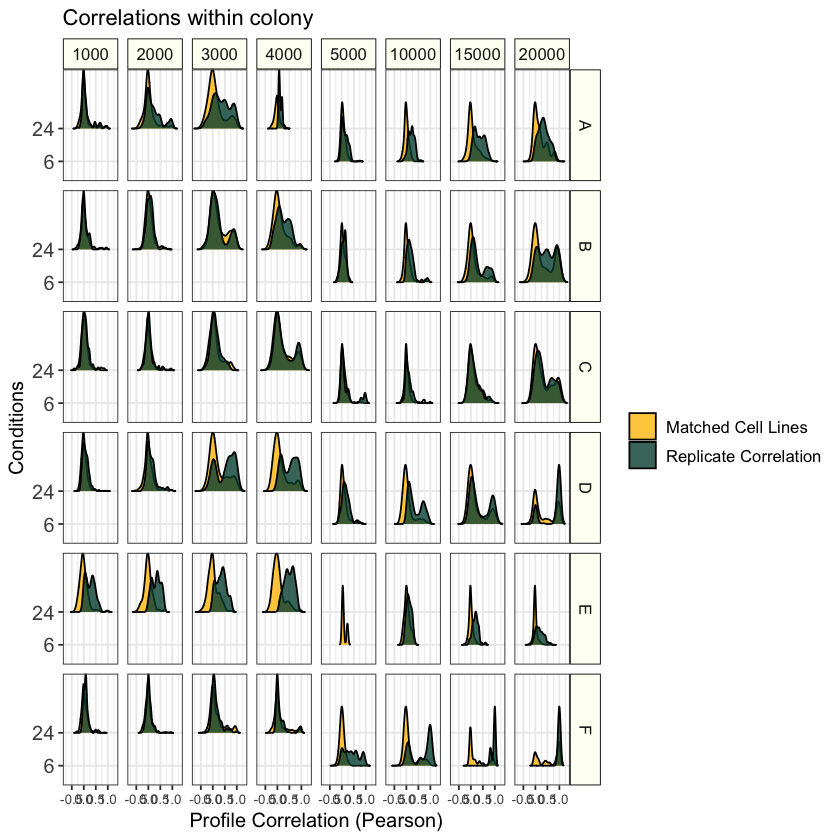

Picking joint bandwidth of 0.0853
Picking joint bandwidth of 0.0691
Picking joint bandwidth of 0.065
Picking joint bandwidth of 0.0473
Picking joint bandwidth of 0.0544
Picking joint bandwidth of 0.0503
Picking joint bandwidth of 0.0636
Picking joint bandwidth of 0.0727
Picking joint bandwidth of 0.0646
Picking joint bandwidth of 0.0712
Picking joint bandwidth of 0.0843
Picking joint bandwidth of 0.0808
Picking joint bandwidth of 0.0608
Picking joint bandwidth of 0.0448
Picking joint bandwidth of 0.0616
Picking joint bandwidth of 0.0711
Picking joint bandwidth of 0.0541
Picking joint bandwidth of 0.0509
Picking joint bandwidth of 0.0687
Picking joint bandwidth of 0.0619
Picking joint bandwidth of 0.0513
Picking joint bandwidth of 0.0554
Picking joint bandwidth of 0.0713
Picking joint bandwidth of 0.066
Picking joint bandwidth of 0.0588
Picking joint bandwidth of 0.0578
Picking joint bandwidth of 0.0656
Picking joint bandwidth of 0.0586
Picking joint bandwidth of 0.0371
Picking joint ba

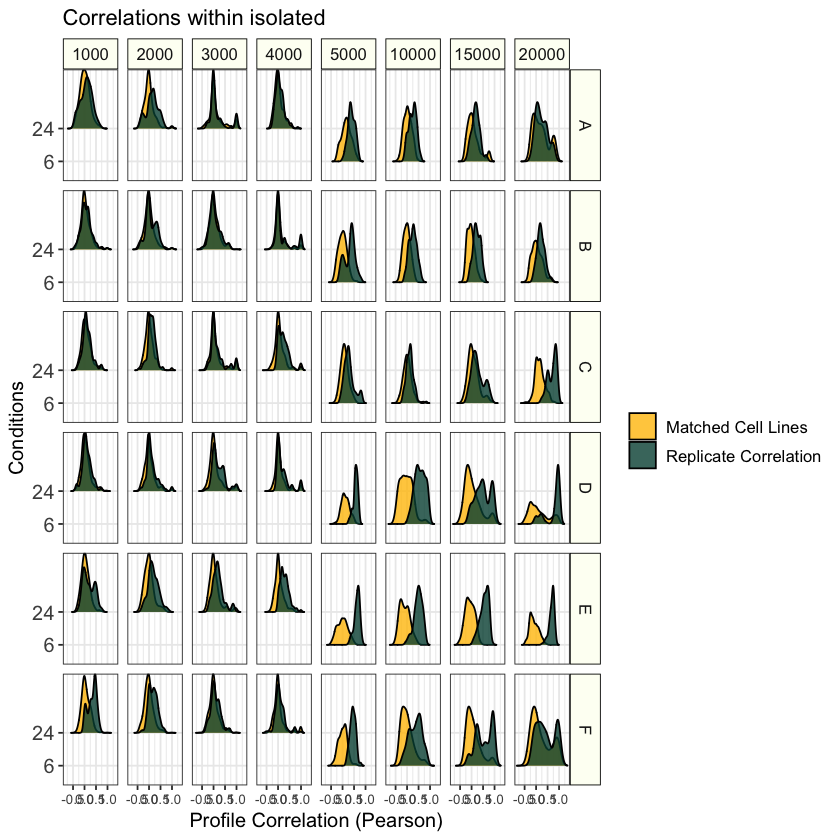

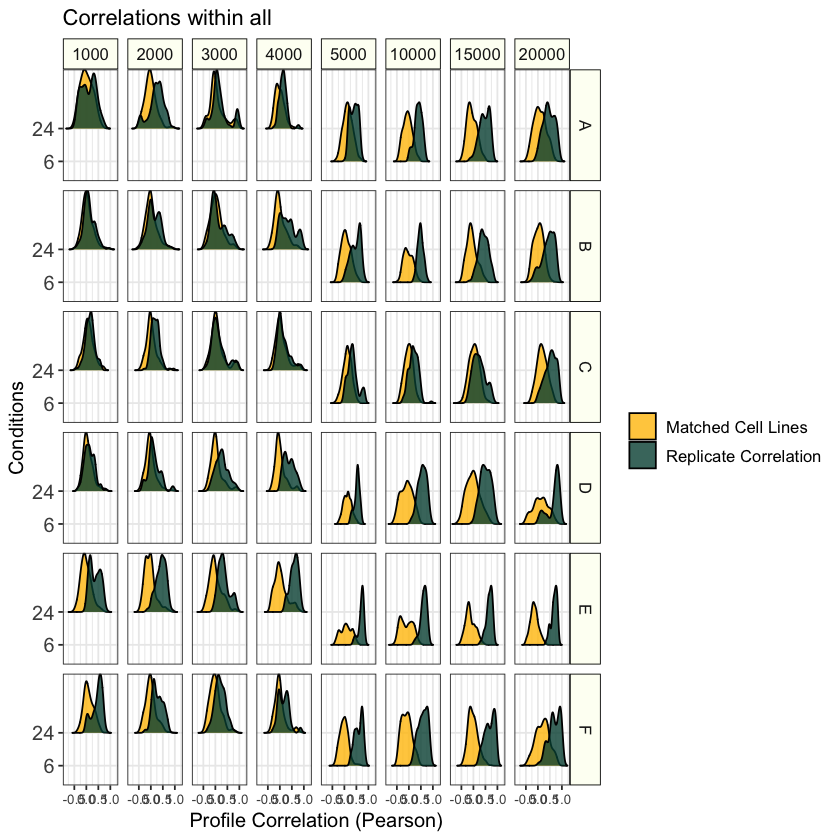

In [14]:
for (sc_type in unique(full_plot_ready$Metadata_profile_type)) {
    sc_full_plot_ready <- full_plot_ready %>%
        dplyr::filter(Metadata_profile_type == sc_type)
    
    condition_gg <-
    ggplot(sc_full_plot_ready,
           aes(x = pearson_cor,
               y = as.factor(Metadata_timepoint),
               fill = null_data)) +
        geom_density_ridges(alpha = 0.8) +
        ylab("Conditions") +
        xlab("Profile Correlation (Pearson)") +
        theme_bw() +
        ggtitle(paste("Correlations within", sc_type)) +
        facet_grid(Metadata_line_ID~Metadata_plating_density,
                   scales="free_y") +
        scale_fill_manual(name = "",
                          values = c("#FFC107", "#004D40")) +
        theme(axis.text.y = element_text(size = 12),
              axis.text.x = element_text(size = 8),
              axis.title = element_text(size = 12),
              legend.text = element_text(size = 10),
              strip.text = element_text(size = 10),
              strip.background = element_rect(colour = "black",
                                              fill = "#fdfff4"))

    print(condition_gg)
    
    file_base <- file.path("figures", paste0("condition_pilot_", sc_type))
    for (extension in c('.png', '.pdf')) {
        ggsave(condition_gg,
               filename = paste0(file_base, extension),
               height = 8,
               width = 10)
    }
}

## Determine Optimal Condition

Warning message:
“Column `pair_b`/`group_condition_id` joining factors with different levels, coercing to character vector”

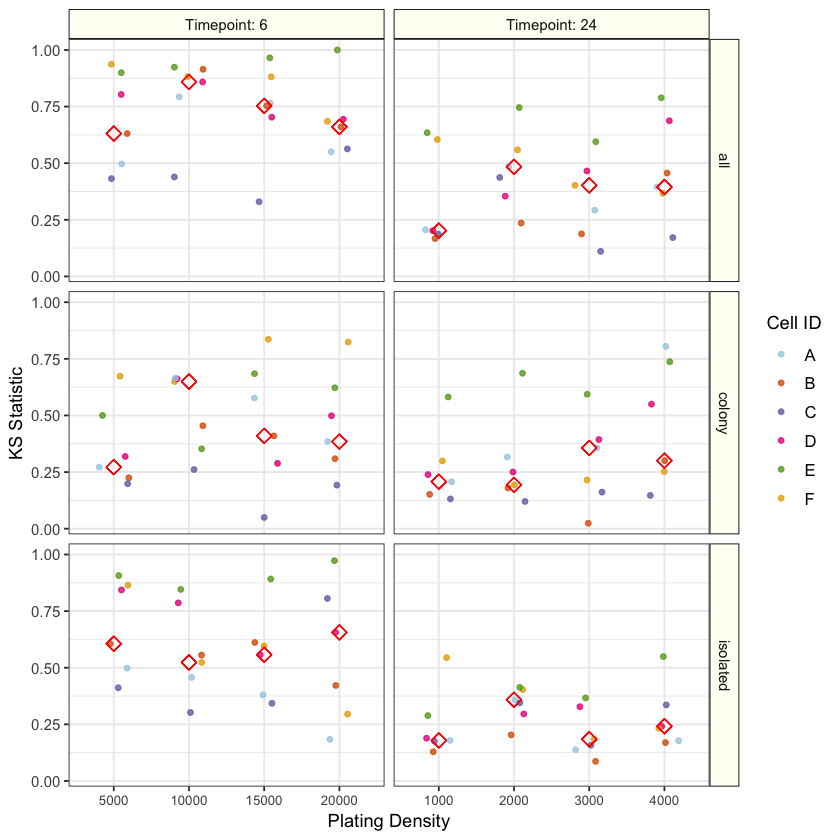

In [15]:
ks_result_df$group_condition_id <- as.factor(ks_result_df$group_condition_id)

final_results_df <- full_plot_ready %>%
    dplyr::left_join(ks_result_df,
                     by = c("pair_b" = "group_condition_id")) %>%
    dplyr::group_by(
        Metadata_profile_type,
        Metadata_timepoint,
        Metadata_plating_density,
        Metadata_line_ID
    ) %>%
    dplyr::mutate(
        median_cell_ks = median(ks_stat)
    ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(
        Metadata_profile_type,
        Metadata_timepoint,
        Metadata_plating_density
    ) %>%
    dplyr::mutate(
        median_condition_ks = median(ks_stat)
    ) %>%
    dplyr::select(
        Metadata_profile_type,
        Metadata_timepoint,
        Metadata_plating_density,
        Metadata_line_ID,
        median_cell_ks,
        median_condition_ks
    ) %>%
    dplyr::distinct() %>%
    dplyr::ungroup()

append_timepoint <- function(string) paste("Timepoint:", string)

ks_test_gg <- ggplot(final_results_df) +
    geom_jitter(aes(y = median_cell_ks,
                    x = as.factor(Metadata_plating_density),
                    color = Metadata_line_ID),
                size = 1.25,
                height = 0,
                width = 0.2,
                alpha = 0.8) +
    geom_point(aes(y = median_condition_ks,
                   x = as.factor(Metadata_plating_density)),
               color = "red",
               shape = 23,
               size = 3) +
    scale_color_manual(name = "Cell ID",
                       values = c("#a6cee3",
                                  "#d95f02",
                                  "#7570b3",
                                  "#e7298a",
                                  "#66a61e",
                                  "#e6ab02")) +
    facet_grid(Metadata_profile_type~Metadata_timepoint,
               scales = "free_x",
               labeller = labeller(Metadata_timepoint = as_labeller(append_timepoint))) +
    xlab("Plating Density") +
    ylab("KS Statistic") +
    theme_bw() +
    theme(axis.text.y = element_text(size = 9),
          axis.text.x = element_text(size = 8),
          axis.title = element_text(size = 11),
          legend.text = element_text(size = 10),
          strip.text = element_text(size = 9),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

ks_test_gg

In [16]:
file_base <- file.path("figures", "condition_pilot_kstest")
for (extension in c('.png', '.pdf')) {
    ggsave(ks_test_gg,
           filename = paste0(file_base, extension),
           height = 6,
           width = 6)
}

## Generate a summary table of KS Test Results

In [17]:
final_results_df <- full_plot_ready %>%
    dplyr::left_join(ks_result_df,
                     by = c("pair_b" = "group_condition_id")) %>%
    dplyr::group_by(
        Metadata_profile_type,
        Metadata_timepoint,
        Metadata_plating_density
    ) %>%
    dplyr::mutate(
        median_ks = median(ks_stat),
        low_ks = min(ks_stat),
        high_ks = max(ks_stat)
    ) %>%
    dplyr::select(
        Metadata_profile_type,
        Metadata_timepoint,
        Metadata_plating_density,
        median_ks,
        low_ks,
        high_ks
    ) %>%
    dplyr::distinct() %>%
    dplyr::ungroup() %>%
    dplyr::arrange(desc(median_ks))

file <- file.path("results", "pilot_condition_results.tsv")
readr::write_tsv(final_results_df, file)

final_results_df

Warning message:
“Column `pair_b`/`group_condition_id` joining factors with different levels, coercing to character vector”

Metadata_profile_type,Metadata_timepoint,Metadata_plating_density,median_ks,low_ks,high_ks
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
all,6,10000,0.8586614,0.43924731,0.9240310
all,6,15000,0.7532051,0.32961783,0.9653846
all,6,20000,0.6605890,0.55032051,1.0000000
isolated,6,20000,0.6558743,0.18365385,0.9727987
colony,6,10000,0.6497175,0.26110130,0.6643939
all,6,5000,0.6308559,0.43190184,0.9368280
isolated,6,5000,0.6058559,0.41165644,0.9070210
isolated,6,15000,0.5572115,0.34288747,0.8919872
isolated,6,10000,0.5234293,0.30241935,0.8457364
